### Import Libraries

In [35]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import requests
from io import StringIO
import csv
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

### Load Dataset

In [2]:
dataset = pd.read_csv('hasil_scraping.csv')
dataset.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,806f0c6e-77ff-45dd-b9b9-4db0d338aa5d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"asli GK jelas, mau login malah kyk di oper ope...",2,8,4.1.1052,2025-04-03 08:28:39,NaN,NaN,4.1.1052
1,5b3f8ca3-1dee-438e-bc61-2d9019d5382d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Mau login selalu stuck di Verifikasi cepat, lo...",1,5,4.1.1033.1,2025-02-09 22:29:38,NaN,NaN,4.1.1033.1
2,3e817104-84e5-4fd5-ba23-587e38fd1533,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tolong kenapa susah benget ya login saya pengg...,1,672,4.1.1033.1,2025-02-10 21:02:26,NaN,NaN,4.1.1033.1
3,da1a2e1c-657b-4834-a494-7d5707ed4df5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Beranda LinkedIn saya sudah bermasalah sejak 2...,2,27,4.1.1044,2025-03-14 06:50:15,NaN,NaN,4.1.1044
4,26e00b60-c0c2-47c4-94b3-26b438442aba,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Apa yang terjadi dengan linkedln saya, sudah l...",1,607,4.1.1023,2025-01-13 09:34:29,NaN,NaN,4.1.1023


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33176 entries, 0 to 33175
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              33176 non-null  object
 1   userName              33176 non-null  object
 2   userImage             33176 non-null  object
 3   content               33135 non-null  object
 4   score                 33176 non-null  int64 
 5   thumbsUpCount         33176 non-null  int64 
 6   reviewCreatedVersion  21995 non-null  object
 7   at                    33176 non-null  object
 8   replyContent          2938 non-null   object
 9   repliedAt             2938 non-null   object
 10  appVersion            21995 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.8+ MB


### Cleaning Dataset

#### Mengingat saya hanya menggunakan kolom content saja maka, saya hanya melakukan cleaning pada kolom content saja

In [4]:
dataset = dataset.dropna(subset=['content'])

In [6]:
dataset = dataset.drop_duplicates(subset=['content'], keep='first')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19471 entries, 0 to 33167
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              19471 non-null  object
 1   userName              19471 non-null  object
 2   userImage             19471 non-null  object
 3   content               19471 non-null  object
 4   score                 19471 non-null  int64 
 5   thumbsUpCount         19471 non-null  int64 
 6   reviewCreatedVersion  12962 non-null  object
 7   at                    19471 non-null  object
 8   replyContent          2069 non-null   object
 9   repliedAt             2069 non-null   object
 10  appVersion            12962 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.8+ MB


### Preprocessing Text

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

In [10]:
# Mengubah semua karakter dalam teks menjadi huruf kecil
def casefoldingText(text): 
    text = text.lower()
    return text

In [11]:
# Memecah atau membagi string, teks menjadi daftar token
def tokenizingText(text): 
    text = word_tokenize(text)
    return text

In [19]:
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak', 'gk','ngga', 'nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","tapi"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [20]:
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text

In [21]:
def listToSentence(word_list):
    sentence = ' '.join(word for word in word_list)
    return sentence

In [22]:
slangwords = {
    "apk": "aplikasi",
    "@": "di",
    "abis": "habis",
    "masi": "masih",
    "bgt": "banget",
    "maks": "maksimal"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [25]:
# Terapkan semua fungsi preprocessing ke kolom content
dataset['processed_content'] = dataset['content'].apply(cleaningText)  # Cleaning text
dataset['processed_content'] = dataset['processed_content'].apply(casefoldingText)  # Case folding
dataset['processed_content'] = dataset['processed_content'].apply(tokenizingText)  # Tokenizing
dataset['processed_content'] = dataset['processed_content'].apply(filteringText)  # Filtering
dataset['processed_content'] = dataset['processed_content'].apply(listToSentence)  # Convert list to sentence
dataset['processed_content'] = dataset['processed_content'].apply(stemmingText)  # Stemming
dataset['processed_content'] = dataset['processed_content'].apply(fix_slangwords)  # Fix slang words

# Tampilkan hasil
dataset[['content', 'processed_content']].head()

,content,processed_content
0,"asli GK jelas, mau login malah kyk di oper ope...",asli login kyk oper oper gin pas mo login apkn...
1,"Mau login selalu stuck di Verifikasi cepat, lo...",login stuck verifikasi cepat loading masuk cob...
2,Tolong kenapa susah benget ya login saya pengg...,tolong susah benget login guna login tibatiba ...
3,Beranda LinkedIn saya sudah bermasalah sejak 2...,beranda linkedin masalah mana beranda tampil i...
4,"Apa yang terjadi dengan linkedln saya, sudah l...",linkedln masuklogin mode buffering terus tulis...


### Pelabelan

In [28]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

# Fungsi untuk menentukan polaritas sentimen dari teks
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]
    
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    
    return polarity

# Terapkan fungsi pelabelan sentimen ke kolom 'processed_content'
dataset['sentiment'] = dataset['processed_content'].apply(sentiment_analysis_lexicon_indonesia)

# Tampilkan hasil
dataset[['content', 'processed_content', 'sentiment']].head()

,content,processed_content,sentiment
0,"asli GK jelas, mau login malah kyk di oper ope...",asli login kyk oper oper gin pas mo login apkn...,positive
1,"Mau login selalu stuck di Verifikasi cepat, lo...",login stuck verifikasi cepat loading masuk cob...,negative
2,Tolong kenapa susah benget ya login saya pengg...,tolong susah benget login guna login tibatiba ...,negative
3,Beranda LinkedIn saya sudah bermasalah sejak 2...,beranda linkedin masalah mana beranda tampil i...,negative
4,"Apa yang terjadi dengan linkedln saya, sudah l...",linkedln masuklogin mode buffering terus tulis...,positive


In [29]:
sentiment_counts = dataset['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    6840
negative    6712
neutral     5919
Name: count, dtype: int64


### Eksplorasi Label

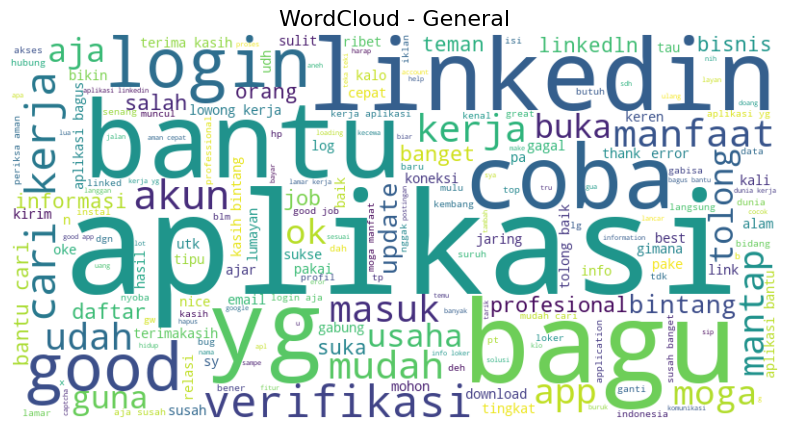

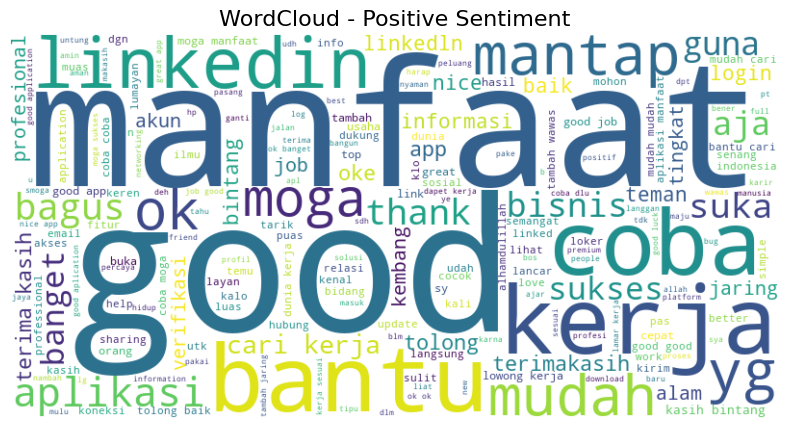

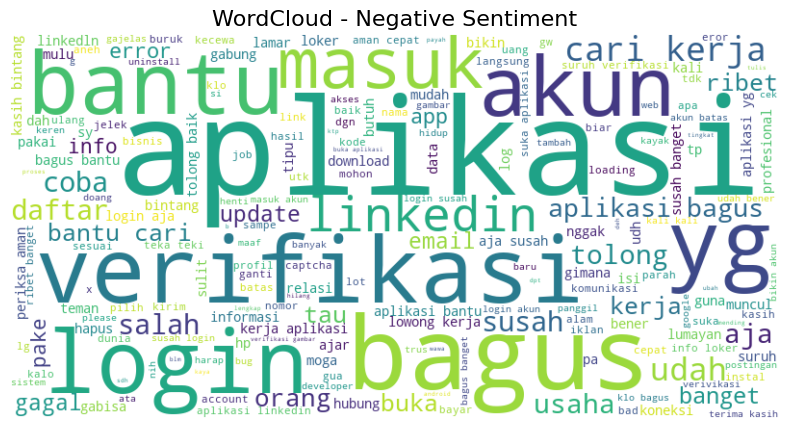

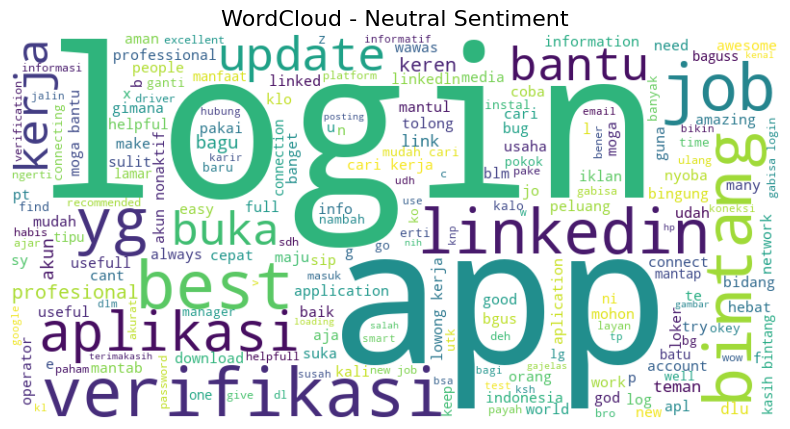

In [31]:
# Fungsi untuk membuat wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Gabungkan semua kata untuk setiap kategori
general_text = ' '.join(dataset['processed_content'])
positive_text = ' '.join(dataset[dataset['sentiment'] == 'positive']['processed_content'])
negative_text = ' '.join(dataset[dataset['sentiment'] == 'negative']['processed_content'])
neutral_text = ' '.join(dataset[dataset['sentiment'] == 'neutral']['processed_content'])

# Buat wordcloud untuk setiap kategori
generate_wordcloud(general_text, 'WordCloud - General')
generate_wordcloud(positive_text, 'WordCloud - Positive Sentiment')
generate_wordcloud(negative_text, 'WordCloud - Negative Sentiment')
generate_wordcloud(neutral_text, 'WordCloud - Neutral Sentiment')

### Data Spliting dan Ekstrasi Fitur

#### Ekstrasi Fitur dengan TF-IDF dan Pembagian Data 80/20

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(dataset['processed_content'])

y = dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")

Jumlah data latih: 15576
Jumlah data uji: 3895


#### Ekstrasi Fitur dengan TF-IDF dan Pembagian Data 70/30

In [37]:
tfidf_vectorizer2 = TfidfVectorizer(max_features=5000)
X_2 = tfidf_vectorizer2.fit_transform(dataset['processed_content'])

y_2 = dataset['sentiment']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

print(f"Jumlah data latih (70/30): {X_train_2.shape[0]}")
print(f"Jumlah data uji (70/30): {X_test_2.shape[0]}")

Jumlah data latih (70/30): 13629
Jumlah data uji (70/30): 5842


#### Ekstrasi Fitur dengan Word2Vec dan Pembagian Data 80/20

In [ ]:
tokenized_content = [text.split() for text in dataset['processed_content']]

word2vec_model = Word2Vec(sentences=tokenized_content, vector_size=100, window=5, min_count=1, workers=4)

def get_average_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_word2vec = np.array([get_average_word2vec(tokens, word2vec_model, 100) for tokens in tokenized_content])

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

print(f"Jumlah data latih: {X_train_w2v.shape[0]}")
print(f"Jumlah data uji: {X_test_w2v.shape[0]}")

Jumlah data latih: 15576
Jumlah data uji: 3895
